We have a CSV file of MLS data from California starting in 2023 with 316,908 unique properties.

The goal, as Keith says, is to "find the neighborhood (or two) with the largest spread and just focus on those two neighborhoods and go buy ‘em all."

Plan:

1. Geographical Clustering by lat/long
First, we need to group the properties into clusters based on their location.

2. Temporal Clustering by closing date
Next, we take those clusters and split them based on the closing date.

3. Attribute Clustering blind to price
We then further cluster the data based on attributes like square footage, lot size, bedrooms, bathrooms, and building type. This step ignores price because our goal is to find neighborhoods with the largest price spread. We don't want to compare properties that are too different (e.g., a small condo vs. a large townhouse). Instead, we calculate the price spread across properties with similar attributes that contribute to price.

4. Calculate price spread of each cluster
Now that we have our clusters, we calculate the price spread using the Interquartile Range (IQR). IQR focuses on the middle 50% of data, ignoring extreme outliers. By measuring the difference between the 75th and 25th percentiles, we capture the core price variability without being skewed by unusually high or low prices. This gives us a reliable sense of the typical price spread for each neighborhood cluster, which is what we need to compare similar properties.

5. Rank the clusters by price spread
Finally, we rank the clusters based on their price spread.

Done.




In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [59]:
def print_large(print_data, max_row=None):
    pd.set_option('display.max_rows', max_row)  # Show all rows
    print(print_data)
    pd.set_option('display.max_rows', 10)

In [60]:
data = pd.read_csv('cleaned_data.csv')
data

/var/folders/x2/02wgr6dd7dq4_fsbqpfv7ybr0000gn/T/ipykernel_13239/2166209516.py:1: DtypeWarning: Columns (17,31,36,46,47,48,53,54,56,58,66,73,78,81,84,88,93,96,97,111,127,157,168) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cleaned_data.csv')


,MLS No,Status,DOM,Address,Unit,City,Area,LP,SP,BT,...,VOW Address,VOW AVM,VOW Comment,VOW Include,WiFi Last,ZIDX Only House #,ZIDX Only Street Dir,ZIDX Only Street Name,Zip,Zoning
0,CROC24045919,SLD,1,24055 Paseo Del Lago,601,LAGUNA WOO,9999,"$24,900","$24,900",CO,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92637,NaN
1,CROC24040584,SLD,1,24055 Paseo Del Lago,613,LAGUNA WOO,9999,"$24,900","$24,900",CO,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92637,NaN
2,CRJT23101637,SLD,267,0 Old Chisholm Trail,NaN,TWENTYNINE,9999,"$43,900","$43,900",DE,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92277,RL-5
3,CRSW24001249,SLD,5,850 San Luis Drive,NaN,HEMET,9999,"$85,000","$85,000",DE,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92543,NaN
4,CRSN24041515,SLD,28,14760 Wildlife Drive,NaN,MAGALIA,9999,"$89,000","$70,000",MN,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,95954,RT-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316903,SF422693331,SLD,205,9 25th Avenue,NaN,SANFRCISCO,9999,"$28,000,000","$20,000,000",DE,...,Yes,No,No,Yes,NaN,NaN,NaN,NaN,94121,NaN
316904,41015329,SLDR,25,4625 Palm Ave,1,SACRAMENTO,9999,"$166,250","$166,250",CO,...,Yes,Yes,Yes,Yes,NaN,4625.0,NaN,Palm Ave,95842,NaN
316905,41014625,SLDR,39,1581 79Th Ave,NaN,OAKLAND,9999,"$323,000","$323,300",DE,...,Yes,Yes,Yes,Yes,NaN,1581.0,NaN,79Th Ave,94621,NaN
316906,41019378,SLDR,16,525 Mota Dr,NaN,BAY POINT,9999,"$599,900","$600,000",DE,...,Yes,Yes,Yes,Yes,NaN,525.0,NaN,Mota Dr,94565,NaN


Need to consider these columns, seems like there's some datatype inconsistency so need to see exactly what the issue is. Most of these columns actually seem pretty useless so shouldn't be a problem, but need to explore what the issue with `Acres` is, since this could be pretty important later on.

In [61]:
data.columns[[17,31,36,47,48,53,54,56,58,66,73,78,81,84,88,93,96,97,111,144,154,157,168]]

Index(['Acres', 'ADU Rents For', 'Agent Has Ownership',
       'Buyer Broker DRE Number', 'Census Tract', 'Co Buy Agent DRE Num.',
       'Co List Agent DRE Num.', 'Co-List Agent Fax', 'Concessions at COE',
       'Disclosures Link', 'Expire Date', 'Foreclosure Status',
       'Geocode Quality', 'HOA Management Companies',
       'Homesnap Appt. Scheduling', 'List Agent DRE Num.', 'Listing Agt Fax',
       'Listing Broker DRE Number', 'Old Concessions',
       'Sales Office Info Remarks', 'Subdivision Profile Rmks',
       'TIC % Owner Offered', 'ZIDX Only House #'],
      dtype='object')

I think the easiest and most fine-graned zoning we can do with this data and without the google api is at the city level. The one caveat is two houses could be in neighboring cities but be very close to each other (in the case they are on the border). However, I don't expect this to be a common occurence to have to worry about it, especially for the purpose of just identifying potential cities to run the google api on. 

I'm not using zip codes here, as I read online that zip codes could potentially overlap geographically and are also updated over time more than cities. Also, a zip codes have additional meaning like navy mail etc, so within a city, a certain area might suddenly have different zip codes than the surrounding houses. These are a little more tricky to deal with so it might be useful to have the google places api for the exact location data for futher fine-grained analysis

In [62]:
counts = data.groupby(['City']).count()['MLS No']
print_large(counts)

City
ACTON           167
ADELANTO        492
AGOURA HIL      204
ALAMEDA         720
ALAMO           266
ALBANY          176
ALHAMBRA        389
ALISO VIEJ      588
ALPINE          135
ALTA LOMA       110
ALTADENA        396
AMERICNYON      134
ANAHEIM        2232
ANTELOPE        587
ANTIOCH        1504
ANZA            157
APPLE VALL     1595
APTOS           390
ARCADIA         795
ARLETA          156
ARROYO GRA      366
ATASCADERO      422
ATHERTON        131
ATWATER         385
AUBURN          797
AZUSA           438
BAKERSFIEL     1148
BALDWIN PA      296
BANNING         652
BARSTOW         457
BAY POINT       207
BEAUMONT       1253
BELLFLOWER      287
BELMONT         282
BENICIA         375
BERKELEY        863
BEVERLY HI      479
BIG BEAR C      167
BIG BEAR L      386
BLOOMINGTO      133
BLYTHE          128
BONITA          103
BORREGO SP      102
BOULDERCRK      178
BREA            383
BRENTWOOD      1064
BUENA PARK      570
BURBANK         881
BURLINGAME      299
CA CITY        

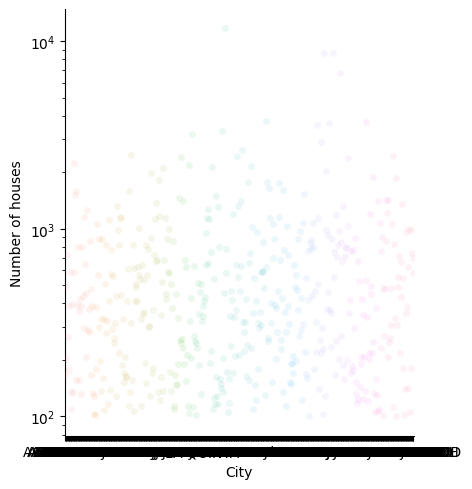

In [46]:
# Convert counts to DataFrame
counts_df = counts.reset_index()

# Plot using seaborn
g = sns.catplot(data=counts_df, x='City', y='MLS No', alpha=0.1)
g.set(yscale="log", ylabel="Number of houses")

In [47]:
print(f"Total number of cities: {len(counts)}")
for threshold in range(10, 100, 10):
    print(f"Number of cities with more than {threshold} records: {sum(counts > threshold)}")

Total number of cities: 489
Number of cities with more than 10 records: 489
Number of cities with more than 20 records: 489
Number of cities with more than 30 records: 489
Number of cities with more than 40 records: 489
Number of cities with more than 50 records: 489
Number of cities with more than 60 records: 489
Number of cities with more than 70 records: 489
Number of cities with more than 80 records: 489
Number of cities with more than 90 records: 489


Few observations:
1. There are a lot of regions with just a few houses. These areas probably do not have enough houses to generate a confident signal in whether there is a valid price spread or not. This can be seen from the rows and also the catplot generated above. On a logarithmic scale, the most dense points are at 1 house and < 10 houses. 
2. It probably makes sense to have a minimum house threshold, but we don't want to keep too high of a threshold such that we lose too many cities in the process. Trying various thresholds and eyeballing it, it seems like around 40 or 50 houses seems to be a good threshold as it keeps ~50% of the data. Though this can be revisited later

In [48]:
CITY_HOUSE_COUNT_THRESHOLD = 100

In [49]:
filtered_cities = list(counts[counts > CITY_HOUSE_COUNT_THRESHOLD].index)
filtered_cities

['ACTON',
 'ADELANTO',
 'AGOURA HIL',
 'ALAMEDA',
 'ALAMO',
 'ALBANY',
 'ALHAMBRA',
 'ALISO VIEJ',
 'ALPINE',
 'ALTA LOMA',
 'ALTADENA',
 'AMERICNYON',
 'ANAHEIM',
 'ANTELOPE',
 'ANTIOCH',
 'ANZA',
 'APPLE VALL',
 'APTOS',
 'ARCADIA',
 'ARLETA',
 'ARROYO GRA',
 'ATASCADERO',
 'ATHERTON',
 'ATWATER',
 'AUBURN',
 'AZUSA',
 'BAKERSFIEL',
 'BALDWIN PA',
 'BANNING',
 'BARSTOW',
 'BAY POINT',
 'BEAUMONT',
 'BELLFLOWER',
 'BELMONT',
 'BENICIA',
 'BERKELEY',
 'BEVERLY HI',
 'BIG BEAR C',
 'BIG BEAR L',
 'BLOOMINGTO',
 'BLYTHE',
 'BONITA',
 'BORREGO SP',
 'BOULDERCRK',
 'BREA',
 'BRENTWOOD',
 'BUENA PARK',
 'BURBANK',
 'BURLINGAME',
 'CA CITY',
 'CALABASAS',
 'CALIMESA',
 'CAMARILLO',
 'CAMBRIA',
 'CAMERONPAK',
 'CAMINO',
 'CAMPBELL',
 'CANOGA PAR',
 'CANYON COU',
 'CANYON LAK',
 'CAPITOLA',
 'CARLSBAD',
 'CARMEL',
 'CARMEL VAL',
 'CARMIC',
 'CARSON',
 'CASTAIC',
 'CASTROVAEY',
 'CATHEDRAL',
 'CERES',
 'CERRITOS',
 'CHATSWORTH',
 'CHERRY VAL',
 'CHICO',
 'CHINO',
 'CHINO HILL',
 'CHOWCHILLA',
 

In [50]:
data = data[data['City'].isin(filtered_cities)]
data

,MLS No,Status,DOM,Address,Unit,City,Area,LP,SP,BT,...,VOW Address,VOW AVM,VOW Comment,VOW Include,WiFi Last,ZIDX Only House #,ZIDX Only Street Dir,ZIDX Only Street Name,Zip,Zoning
0,CROC24045919,SLD,1,24055 Paseo Del Lago,601,LAGUNA WOO,9999,"$24,900","$24,900",CO,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92637,NaN
1,CROC24040584,SLD,1,24055 Paseo Del Lago,613,LAGUNA WOO,9999,"$24,900","$24,900",CO,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92637,NaN
2,CRJT23101637,SLD,267,0 Old Chisholm Trail,NaN,TWENTYNINE,9999,"$43,900","$43,900",DE,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92277,RL-5
3,CRSW24001249,SLD,5,850 San Luis Drive,NaN,HEMET,9999,"$85,000","$85,000",DE,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,92543,NaN
4,CRSN24041515,SLD,28,14760 Wildlife Drive,NaN,MAGALIA,9999,"$89,000","$70,000",MN,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,95954,RT-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316903,SF422693331,SLD,205,9 25th Avenue,NaN,SANFRCISCO,9999,"$28,000,000","$20,000,000",DE,...,Yes,No,No,Yes,NaN,NaN,NaN,NaN,94121,NaN
316904,41015329,SLDR,25,4625 Palm Ave,1,SACRAMENTO,9999,"$166,250","$166,250",CO,...,Yes,Yes,Yes,Yes,NaN,4625.0,NaN,Palm Ave,95842,NaN
316905,41014625,SLDR,39,1581 79Th Ave,NaN,OAKLAND,9999,"$323,000","$323,300",DE,...,Yes,Yes,Yes,Yes,NaN,1581.0,NaN,79Th Ave,94621,NaN
316906,41019378,SLDR,16,525 Mota Dr,NaN,BAY POINT,9999,"$599,900","$600,000",DE,...,Yes,Yes,Yes,Yes,NaN,525.0,NaN,Mota Dr,94565,NaN


Printing out some columns of interest below that could characterize a house's raw attributes (a proxy to check for equality of houses if the house could be demolished and rebuilt. LP is the listing price which is what we want to do the analysis on).

Looking at the sample below, it seems like the data is quite noisy. `Area` seems to be practically useless with a lot of values at 9999. `SqFt`, `Acres` and `Lot SqFt` seem to be good attributes.

In [51]:
data[['MLS No', 'LP', 'SqFt', 'Area', 'BT', 'BR', 'Bth', 'Acres', 'Lot SqFt', 'Age', 'Zip']].head(50)

,MLS No,LP,SqFt,Area,BT,BR,Bth,Acres,Lot SqFt,Age,Zip
0,CROC24045919,"$24,900",625.0,9999,CO,1.0,1.0,NaN,NaN,NaN,92637
1,CROC24040584,"$24,900",500.0,9999,CO,0.0,1.0,0.011500,500,NaN,92637
2,CRJT23101637,"$43,900",400.0,9999,DE,0.0,0.0,4.640000,"202,118",NaN,92277
3,CRSW24001249,"$85,000",800.0,9999,DE,2.0,1.0,0.080000,"3,485",NaN,92543
4,CRSN24041515,"$89,000",1080.0,9999,MN,2.0,1.0,0.325400,"14,174",NaN,95954
...,...,...,...,...,...,...,...,...,...,...,...
45,41051503,"$196,999",903.0,9999,TH,2.0,1.0,0.000000,0,55.0,94509
46,CRSW24041875,"$198,000",841.0,9999,DE,2.0,1.0,0.189600,"8,260",NaN,92277
47,CROC24046164,"$198,800",3018.0,9999,DE,3.0,3.0,4.820000,"209,959",NaN,92372
48,CRHD24047207,"$199,000",1040.0,9999,DE,3.0,1.0,0.160700,"7,000",NaN,92311


In [63]:
# the data in some of these columns contians commas, so couldn't be parsed as a float by pandas from the get-go. Converting these to the right datatype.

cols = ['LP', 'SqFt', 'Acres', 'Lot SqFt']
for col in cols:
    if data[col].dtype == 'O':
        data[col] = pd.to_numeric(data[col].str.replace('[\$,]', '', regex=True), errors='coerce')

data[['MLS No', 'LP', 'SqFt', 'Area', 'BT', 'BR', 'Bth', 'Acres', 'Lot SqFt', 'Age', 'Zip']].head(50)

,MLS No,LP,SqFt,Area,BT,BR,Bth,Acres,Lot SqFt,Age,Zip
0,CROC24045919,24900.0,625.0,9999,CO,1.0,1.0,NaN,NaN,NaN,92637
1,CROC24040584,24900.0,500.0,9999,CO,0.0,1.0,0.0115,500.0,NaN,92637
2,CRJT23101637,43900.0,400.0,9999,DE,0.0,0.0,4.6400,202118.0,NaN,92277
3,CRSW24001249,85000.0,800.0,9999,DE,2.0,1.0,0.0800,3485.0,NaN,92543
4,CRSN24041515,89000.0,1080.0,9999,MN,2.0,1.0,0.3254,14174.0,NaN,95954
...,...,...,...,...,...,...,...,...,...,...,...
45,41051503,196999.0,903.0,9999,TH,2.0,1.0,0.0000,0.0,55.0,94509
46,CRSW24041875,198000.0,841.0,9999,DE,2.0,1.0,0.1896,8260.0,NaN,92277
47,CROC24046164,198800.0,3018.0,9999,DE,3.0,3.0,4.8200,209959.0,NaN,92372
48,CRHD24047207,199000.0,1040.0,9999,DE,3.0,1.0,0.1607,7000.0,NaN,92311


Potential approach from here:
1. Pick columns that accurately represent a house's value if the actual construction is irrelevant (location, lot area, house area, etc). group houses with similar statistics.
2. Build an isolation forest on price of these grouped houses. This could be really good because isolation forest works on the number of decision tree splits required to separate the data (where the splits are made randomly). If the point requires only a few splits to separate the data, it's likely an outlier. Because of this, we can identify houses which have a price abnormality, which would include houses on the upper end but could also identify houses on the lower end. 

Now we need to come up with a good appraoch for grouping houses. I tried a few approaches here, this is a slightly non-trivial task. Here's the final approach I came up with:

For example, if there are 3 houses: A, B and C where square footage is in the order of A < B < C. In B's group, A and C should be present, but in A's group only B should be present. So the idea is one house should be able to appear in multiple groups, and there should be a threshold for how far away the square footage can be within each group. This way, if we go over each group and find abnormalities in the price, we should be able to find low-balled houses without having to do smart grouping and deduping (slightly inefficient time complexity wise but works for this dataset).

The 12.5% threshold is quite arbitrary here, and this could be more informed based on some industry insight where houses within a certain range of sq ft usually sell for around the same price.

In [54]:
from sklearn.neighbors import NearestNeighbors

# Parameters for the 12.5% filter
tolerance = 0.125

data_not_null = data[['MLS No', 'SqFt', 'Acres', 'Lot SqFt', 'BT', 'City', 'SP']].dropna()
# Normalize the data (MinMaxScaler can also be used, but we'll manually normalize here)
df_norm = data_not_null[['SqFt', 'Acres', 'Lot SqFt']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Nearest Neighbors model
nbrs = NearestNeighbors(n_neighbors=50, algorithm='auto').fit(df_norm)

# Find the 25 nearest neighbors for each house
distances, indices = nbrs.kneighbors(df_norm)

# Function to check if a house is within 10% tolerance
def within_10_percent(row1, row2):
    return (abs(row1['SqFt'] - row2['SqFt']) / row1['SqFt'] <= tolerance and
#             abs(row1['Acres'] - row2['Acres']) / row1['Acres'] <= tolerance and
            row1['BT'] == row2['BT'] and
            row1['City'] == row2['City'])
#             abs(row1['Lot SqFt'] - row2['Lot SqFt']) / row1['Lot SqFt'] <= tolerance)

# Filter neighbors based on the 10% tolerance
closest_houses = {}
j = 0
for i, house_row in data_not_null.iterrows():
    similar_houses = []
    
    for idx in indices[j]:
        comparison_row = data_not_null.iloc[idx]
        if within_10_percent(house_row, comparison_row):
            similar_houses.append(comparison_row['MLS No'])
    
    closest_houses[house_row['MLS No']] = similar_houses
    j += 1


/var/folders/x2/02wgr6dd7dq4_fsbqpfv7ybr0000gn/T/ipykernel_13239/312366923.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return (abs(row1['SqFt'] - row2['SqFt']) / row1['SqFt'] <= tolerance and
/var/folders/x2/02wgr6dd7dq4_fsbqpfv7ybr0000gn/T/ipykernel_13239/312366923.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  return (abs(row1['SqFt'] - row2['SqFt']) / row1['SqFt'] <= tolerance and


In [ ]:
# Display the results
i = 16
house, similar_houses = list(closest_houses.items())[i]
data_not_null[data_not_null['MLS No'].isin(similar_houses)]

,MLS No,SqFt,Acres,Lot SqFt,BT,City,LP
22,CRJT24030218,880.0,5.0,217800.0,DE,TWENTYNINE,127000.0
100528,CRJT22168564,867.0,5.1,222156.0,DE,TWENTYNINE,345000.0
260109,CRJT24005706,880.0,5.0,217800.0,DE,TWENTYNINE,280000.0


In [ ]:
num_neighbors = []
for house, similar_houses in closest_houses.items():
    num_neighbors.append(len(similar_houses))
num_neighbors = np.array(num_neighbors)
num_neighbors

array([11, 13,  1, ...,  2,  1,  4])

Checking to see if the conditions we have in place are too tight. I've plotted the distribution for the number of neighbors, and around 11% of houses have atleast 5 neighbors, which seems like a good percentage.

In [ ]:
sum(num_neighbors >= 5) / len(num_neighbors)

0.10933710243470683

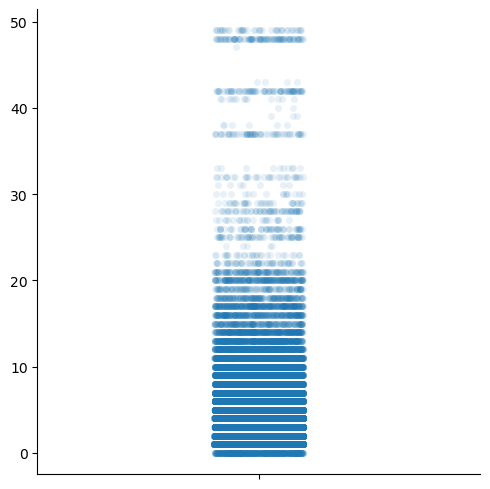

In [ ]:
sns.catplot(num_neighbors, alpha=0.1)

Now that we have a grouping on the houses, we can run isolation forests on each of these groups to see if there are any potential abnormalities.

In [ ]:
from sklearn.ensemble import IsolationForest

def get_scores(prices):
    clf = IsolationForest(random_state=42, n_estimators=10, bootstrap=False)
    prices = np.array(prices)
    prices = prices.reshape(-1, 1)
    return clf.fit_predict(prices)
#     return clf.decision_function(prices)

In [ ]:
# Display the results
# some potential values to try: i = 0, i = 10. can see that outliers (both on the positive end and negative end are relatively reasonably identified)
i = 10
house, similar_houses = list(closest_houses.items())[i]
prices = data_not_null[data_not_null['MLS No'].isin(similar_houses)]['SP'].values
prices = list(prices)
prices.append(data_not_null[data_not_null['MLS No'].isin([house])]['SP'].values[0])
get_scores(prices), prices

(array([ 1, -1,  1,  1, -1,  1]),
 [99000.0, 75000.0, 165000.0, 165000.0, 182999.0, 99000.0])

It seems like the outliers are well identified by the isolation forest. Just tried it on a few samples manually, and it does identify houses on the low end as well as the high end well. For example, for `i=10`, $75000 does seem to be low compared to the prices of the other houses. 

Now running on all groups. The idea is if any group has outliers and any of the outliers are < 60% of the mean value (again sort of arbitrary and can be adjusted for the actual number that has worked for Keith so far), we want to possibly investigate them further.

Below cell takes quite some time to run since we're building a lot of isolation forests. Run sparingly

In [ ]:
mls_no_to_study = []
print(f"Total of {len(list(closest_houses.items()))} houses")
i = 0
for house, similar_houses in closest_houses.items():
    if i % 1000 == 0:
        print(f"Finished {i + 1} houses")
    i += 1
    if len(similar_houses) < 5:
        continue
    prices = data_not_null[data_not_null['MLS No'].isin(similar_houses)]['SP'].values
    prices = list(prices)
    prices.append(data_not_null[data_not_null['MLS No'].isin([house])]['SP'].values[0])
    scores = get_scores(prices)
    prices = np.array(prices)
    mean_price = np.mean(prices)
    negative_score_indices = np.where(scores < 0)
    result = np.any(prices[negative_score_indices] < 0.6 * mean_price)
    if result:
        mls_no_to_study.append(similar_houses + [house])

Total of 291493 houses
Finished 1 houses
Finished 1001 houses
Finished 2001 houses
Finished 3001 houses
Finished 4001 houses
Finished 5001 houses
Finished 6001 houses
Finished 7001 houses
Finished 8001 houses
Finished 9001 houses
Finished 10001 houses
Finished 11001 houses
Finished 12001 houses
Finished 13001 houses
Finished 14001 houses
Finished 15001 houses
Finished 16001 houses
Finished 17001 houses
Finished 18001 houses
Finished 19001 houses
Finished 20001 houses
Finished 21001 houses
Finished 22001 houses
Finished 23001 houses
Finished 24001 houses
Finished 25001 houses
Finished 26001 houses
Finished 27001 houses
Finished 28001 houses
Finished 29001 houses
Finished 30001 houses
Finished 31001 houses
Finished 32001 houses
Finished 33001 houses
Finished 34001 houses
Finished 35001 houses
Finished 36001 houses
Finished 37001 houses
Finished 38001 houses
Finished 39001 houses
Finished 40001 houses
Finished 41001 houses
Finished 42001 houses
Finished 43001 houses
Finished 44001 houses


In [ ]:
len(mls_no_to_study)

1446

In [ ]:
with open("mls_no_to_study.txt", "w") as f:
    f.write(str(mls_no_to_study))